# LLM Society: Complete User Guide

This notebook teaches how to use the `llm-society` package end-to-end:

- Installation and API key setup
- Quick start (simple and complex contagion modes)
- Object-oriented API (LLM mode)
- Visualizations via a single entrypoint `net.plot(type=...)`
- Persona segments
- Scheduled interventions with `intervention_content`
- Using a custom NetworkX graph (real data)
- Conversation retrieval (by round and node pair)
- Summary panel and exporting results
- CLI usage
- Tips for cost control and reproducibility



## 1) Installation and setup

```bash
pip install llm-society
```

LLM mode requires an OpenAI API key:
```bash
export OPENAI_API_KEY=<YOUR_OPENAI_API_KEY>
# Or save to file (gitignored):
echo "<YOUR_OPENAI_API_KEY>" > api-key.txt
```
The library reads from `OPENAI_API_KEY` or `OPENAI_API_KEY_FILE`.



In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "<YOUR_OPENAI_API_KEY>"

In [3]:
# Imports
from llm_society import network
import matplotlib.pyplot as plt

## 2) Quick start: simple and complex contagion
Use non-LLM modes for fast demos and theory comparisons.



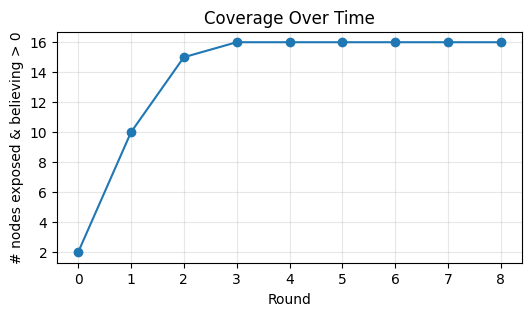

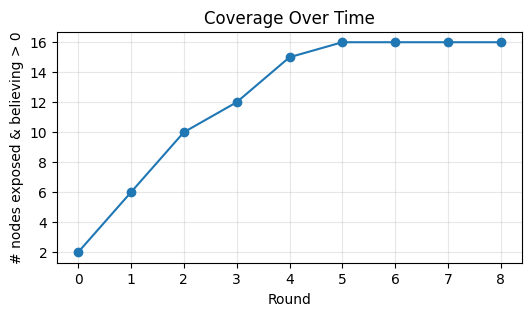

In [4]:
# Simple contagion
net_simple = network(
    information="Increasing the carbon tax will reduce emissions.",
    n=16, degree=4, rounds=8,
    depth=0.5, depth_max=4, edge_frac=0.5,
    seeds=[0,1], seed_belief=0.9,
    mode="simple", rng=0,
)
net_simple.simulate()
net_simple.plot(type="coverage")

# Complex contagion (threshold k)
net_complex = network(
    information="Public transit expansion will reduce traffic congestion.",
    n=16, degree=4, rounds=8,
    depth=0.5, depth_max=4, edge_frac=0.5,
    seeds=[0,1], seed_belief=0.9,
    mode="complex", rng=0,
)
net_complex.simulate()
net_complex.plot(type="coverage")



## 3) Stepwise simulation (pause and resume)
`step()` advances one round at a time and accumulates `history`.



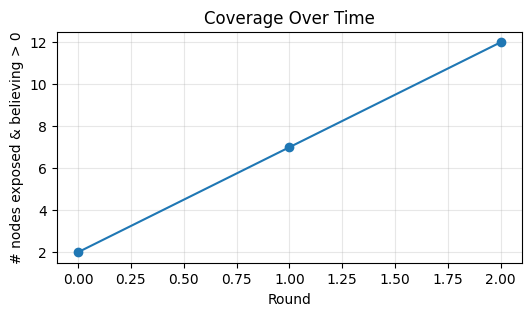

In [5]:
net_step = network(
    information="Urban greening improves public health.",
    n=14, degree=3, rounds=10,
    depth=0.5, depth_max=4, edge_frac=0.5,
    seeds=[0,1], seed_belief=0.9,
    mode="simple", rng=1,
)
count = 0
while net_step.step():
    count += 1
    if count >= 3:
        break
net_step.plot(type="coverage")



## 4) LLM mode (conversations + belief updates)
This mode uses short, natural-sounding conversations to update beliefs.



Round 0 summary: Most people are skeptical that expanding vocational training will boost employment.

=== Conversation 0 <-> 6 ===
0: Absolutely, let's switch it up! What's something fun or relaxing you've done lately?
6: I actually took some time to walk in the park and just enjoy the fresh air. Sometimes, just sitting on a bench and people-watching can be the most relaxing thing.
0: That sounds so lovely! I think we all need little breaks like that now and then to just breathe and reset.
6: Absolutely, man. Life moves so fast, it’s important to just pause and take it all in sometimes.
(No information discussed; beliefs unchanged.)
=== End Conversation 0 <-> 6 ===


=== Conversation 2 <-> 9 ===
2: Sure, I'm up for anything! What's been on your mind lately?
9: Honestly, I've just been thinking about how fast this year is flying by. Feels like I blinked and it's already June!
2: I know, right? It’s wild how quickly time is moving—before we know it, it'll be the holidays again!
9: Seriou

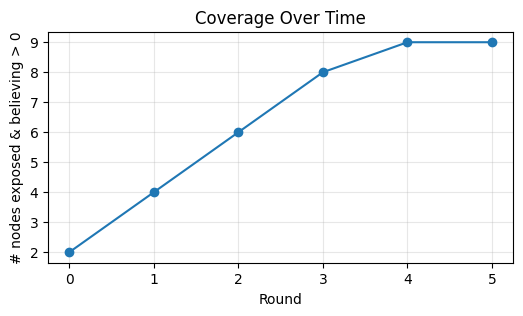

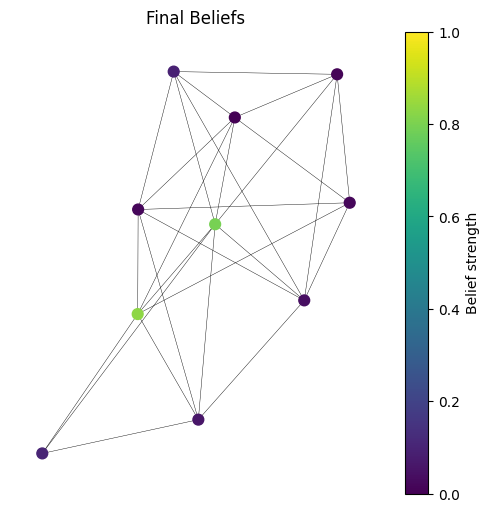

In [8]:
net_llm = network(
    information="Expanding vocational training will increase employment.",
    n=10, degree=4, rounds=5,
    depth=0.5, depth_max=4, edge_frac=0.5,
    seeds=[0,1], seed_belief=0.95, talk_prob=0.5,
    mode="llm", rng=0, model="gpt-4.1",
)
net_llm.simulate()
net_llm.plot(type="coverage")
net_llm.plot(type="final_beliefs")

## 5) Visualizations with a single entrypoint
Available plot `type`s:
- `animation`, `coverage`, `final_beliefs`
- `group_beliefs` (kwargs: `attr="political"`)
- `centrality` (kwargs: `metric="degree"|"betweenness"|"eigenvector"`)
- `intervention_effect` (kwargs: `intervention_round=int`, optional; auto-detected if omitted)



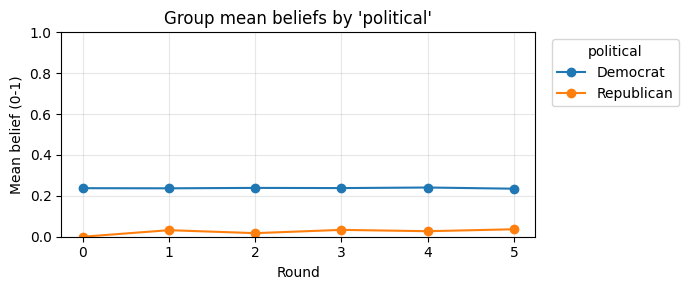

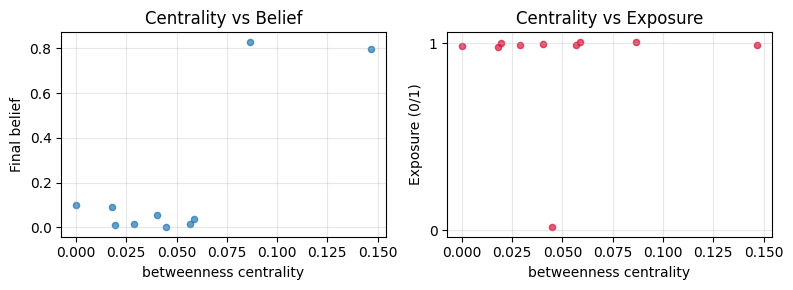

In [9]:
# Group means and centrality plots
net_llm.plot(type="group_beliefs", attr="political")
net_llm.plot(type="centrality", metric="betweenness")



## 6) Persona segments
Segments allow you to define sub-populations with different trait distributions.



Round 0 summary: Most people doubt that raising gas taxes will greatly lower inflation.

=== Conversation 5 <-> 9 ===
5: Honestly, I don't really buy that at all. Raising gas taxes usually just makes things more expensive for everyone, not the other way around.
9: I totally agree with you. Higher gas taxes tend to drive up costs across the board, not bring prices down.
=== End Conversation 5 <-> 9 ===

Belief update 5<->9: 5 0.00 -> 0.00, 9 0.00 -> 0.00

=== Conversation 1 <-> 5 ===
1: Yeah, for sure. What’s been on your mind lately?
5: Honestly, I’ve just been trying to figure out some plans for the summer and thinking about how fast this year’s going by. How about you?
1: Same here honestly, this year is flying by. I’m just looking forward to having some chill time this summer, maybe hang with friends and catch up on stuff I’ve been putting off.
5: I feel you, summer can’t come soon enough. I just want to relax, maybe go to the lake or just do nothing with friends for a while.
1: Man

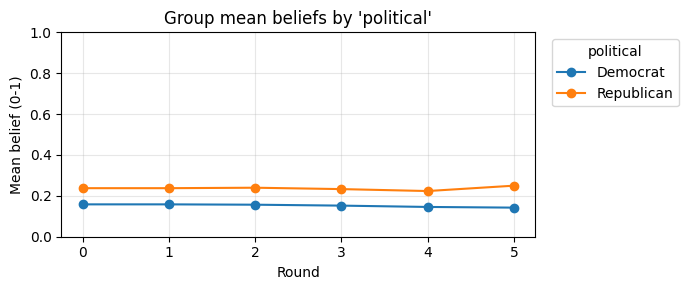

In [10]:
segments = [
    {"proportion": 0.5, "traits": {"political": {"choices": {"Democrat": 0.8, "Republican": 0.2}}}},
    {"proportion": 0.5, "traits": {"political": {"choices": {"Democrat": 0.2, "Republican": 0.8}}}},
]

net_seg = network(
    information="Increasing gas taxes will significantly reduce inflation.",
    n=10, degree=4, rounds=5,
    depth=0.5, depth_max=4, edge_frac=0.5,
    seeds=[0,1], seed_belief=0.95, talk_prob=0.5,
    mode="llm", rng=1, model="gpt-4.1",
    segments=segments,
)
net_seg.simulate()
net_seg.plot(type="group_beliefs", attr="political")



## 7) Scheduled interventions (content injection)
From a given round onward, inject `intervention_content` into the system message of targeted nodes.



Round 0 summary: Most people are skeptical that higher gas taxes will greatly lower inflation.

=== Conversation 2 <-> 3 ===
2: I actually don’t think increasing gas taxes would do much to reduce inflation. If anything, higher gas taxes could just make things more expensive for everyone.
3: Yeah, I totally agree. Raising gas taxes usually just bumps up costs for transportation and goods, so it might actually add to inflation instead of bringing it down.
2: Exactly, higher gas taxes can make everything more expensive, not less. It seems like it would just put more pressure on everyday people instead of actually solving inflation.
3: Yeah, I totally agree with you. Raising gas taxes usually just ends up costing folks more, and I don’t really see how it would help bring down inflation at all.
2: Exactly, higher gas taxes just make everything more expensive, especially because so much depends on transportation. It just puts more strain on regular people without actually fixing the inflatio

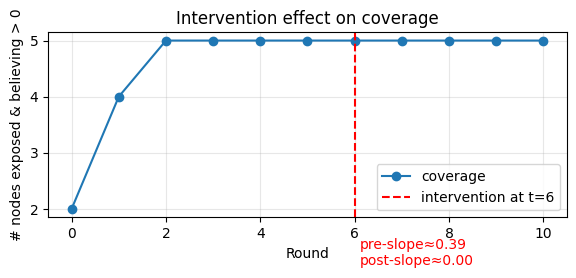

In [11]:
net_int = network(
    information="Increasing gas taxes will significantly reduce inflation.",
    n=5, degree=4, rounds=10,
    depth=0.5, depth_max=4, edge_frac=0.5,
    seeds=[0,1], seed_belief=0.95, talk_prob=0.5,
    mode="llm", rng=0, model="gpt-4.1",
    intervention_round=6,
    intervention_nodes=[2,5,7,11,13,17],
    intervention_content="Write a letter to each other.",
)
net_int.simulate()
net_int.plot(type="intervention_effect", intervention_round=6)



## 11) CLI usage

Write an example config:
```bash
llm-society --write-example-config my-config.yaml
```
Run a simulation from config:
```bash
llm-society --config my-config.yaml
```
Override parameters via flags:
```bash
llm-society --config my-config.yaml --depth 0.8 --rounds 20
```
Run fully via flags (with intervention content):
```bash
llm-society \
  --information "Increasing gas taxes will significantly reduce inflation." \
  --n 24 --degree 4 --rounds 10 \
  --depth 0.5 --depth-max 4 --edge-frac 0.5 \
  --seeds 0,1 --seed-belief 0.95 --talk-prob 0.5 \
  --mode llm --rng 0 --model gpt-4.1 \
  --intervention-round 6 --intervention-nodes 2,5,7,11,13,17 \
  --intervention-content "Write a letter to each other."
```



## 12) Tips for cost control and reproducibility
- Use `mode="simple"` or `mode="complex"` for dry-runs.
- Reduce `n`, `rounds`, `edge_frac`, `depth`/`max_convo_turns`, and `talk_prob` to cut LLM calls.
- Set `rng` to a fixed seed for reproducibility.
- Prefer `group_beliefs`, `coverage` for fast, high-signal visual summaries.

